# Introduction

Use the TensorFlow package to identify between cats and dogs in a set of images.

This assignment is based on the [Kaggle competition] Cats vs. Dogs (https://www.kaggle.com/competitions/dogs-vs-cats) 

# Import Packages and files + inspect images


In [ ]:
#Initial packages to start
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
import glob

#Models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

#Callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/R2/Data/dogs-vs-cats/train.zip > /dev/null

In [ ]:
!unzip /content/gdrive/MyDrive/R2/Data/dogs-vs-cats/test1.zip > /dev/null

The files in the training set identify the category names in the filename

In [ ]:
img = load_img('train/dog.103.jpg')
img

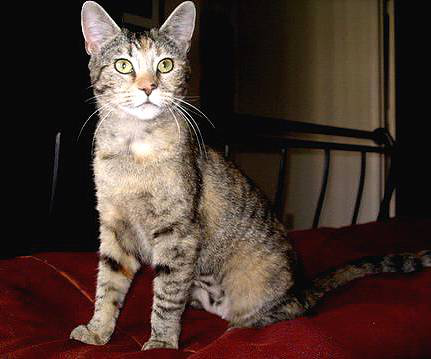

In [ ]:
img = load_img('train/cat.10000.jpg')
img

# Put test and training data into dataframes


In [ ]:
# Make sure I have the right number of files in the training set
total_train = len(os.listdir('./train')) 
total_train

25000

In [ ]:
# Get category names out of filenames
filenames = os.listdir('./train')
len(filenames)

25000

In [ ]:
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')

In [ ]:
# Create training DF
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head(10)

,filename,category
0,dog.11182.jpg,dog
1,cat.11906.jpg,cat
2,cat.8475.jpg,cat
3,dog.11744.jpg,dog
4,cat.3020.jpg,cat
5,dog.3003.jpg,dog
6,dog.2117.jpg,dog
7,cat.3599.jpg,cat
8,cat.8064.jpg,cat
9,dog.5322.jpg,dog


In [ ]:
# There are no nans. Will drop duplicates...although there don't seem to be any.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  25000 non-null  object
 1   category  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [ ]:
df.drop_duplicates(inplace=True)

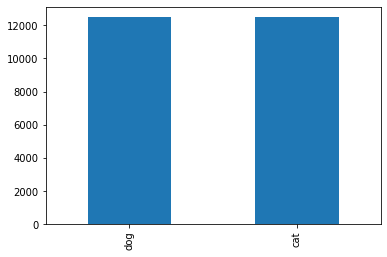

In [ ]:
# The categories in the training set are balanced. Great!

df['category'].value_counts().plot.bar()

cat.12153.jpg


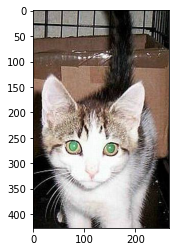

In [ ]:
# Take a look at the images
sample = random.choice(df['filename'])

image = load_img("./train/"+sample)
plt.imshow(image)
print(sample)

In [ ]:
# Put testing data into DF
test_filenames = os.listdir("./test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
total_samples = test_df.shape[0]

In [ ]:
test_df.head(10)

,filename
0,4589.jpg
1,2967.jpg
2,7997.jpg
3,10826.jpg
4,3688.jpg
5,7041.jpg
6,2478.jpg
7,4224.jpg
8,5812.jpg
9,10074.jpg


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  12500 non-null  object
dtypes: object(1)
memory usage: 97.8+ KB


9903.jpg


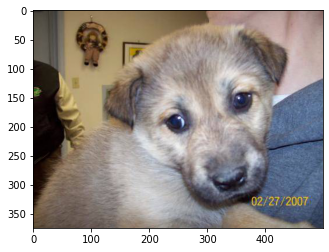

In [ ]:
sample = random.choice(test_df['filename'])

image = load_img("./test1/"+sample)
plt.imshow(image)
print(sample)

# Prep Training Data and Create Train Generator



Ad train/test splot and load Data with Keras

The dataset looks clean but the dimensions aren't constant.

I'll use keras's ImageDataGenerator to rescale the images, batch them. I'll also do data augmentation but slightly modifying the images. It also takes care of one-hot encoding.

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

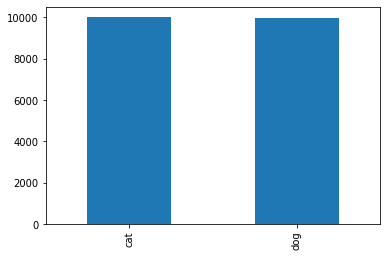

In [ ]:
train_df['category'].value_counts().plot.bar()

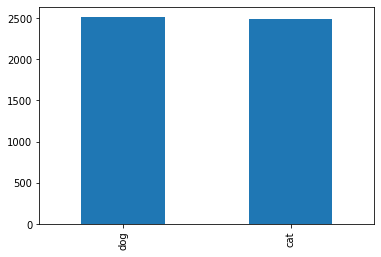

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [ ]:
train_df.shape[0]

20000

In [ ]:
validate_df.shape[0]

5000

In [ ]:
#Define image size
img_height = 224
img_width = 224
batch_size = 15
image_size = (img_width, img_height)

In [ ]:
# Make the ImageDataGenerator object
#I'm using standard parameters for this
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

I'm going to use Flow from Dataframe using the df I created. Making a Training Generator and a Validation Generator.

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


Take a look at the modified images...

In [ ]:
example_df = train_df.sample(1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=(img_height, img_width),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


I'm making a note of this image: cat.10181.jpg. It is labeled as cat but it has both a dog and cat. Will be interested to run this thru the model at the end to see how it's identified.

In [ ]:
example_df

,filename,category
0,dog.4337.jpg,dog


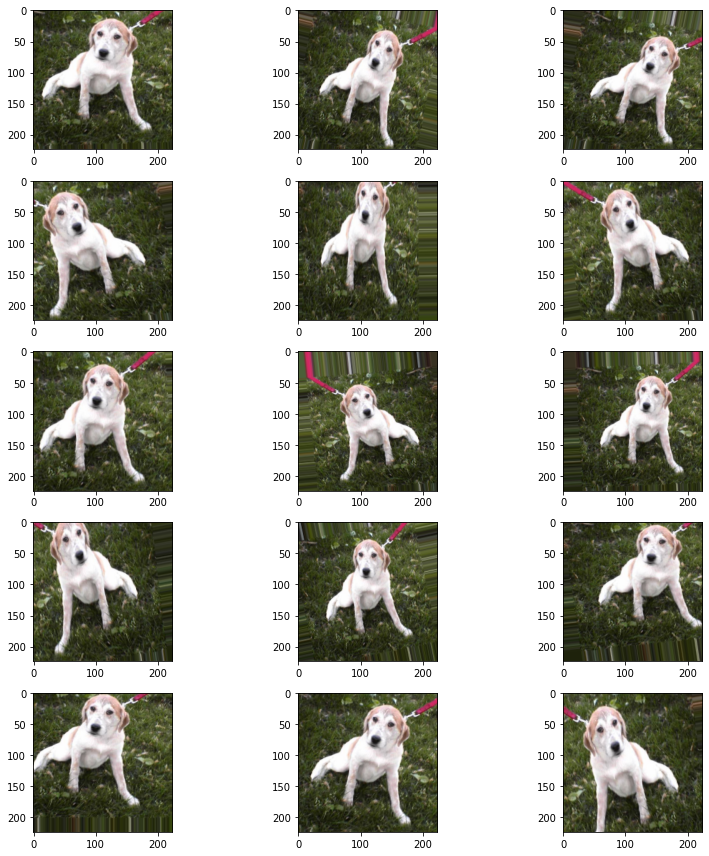

In [ ]:


plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Make Callbacks


In [ ]:
# Stop learning after 10 epochs if the loss value doesn't decrease
earlystop = EarlyStopping(patience=10)

In [ ]:
# Reduce the learning rate by monitoring accuracy. If accuracy doesn't increase after 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            factor=0.5, 
                                            min_lr=0.00001)

I have just learned the hard way that google.colab times out after 90 minutes, so now I need to rerun my model...I'm now adding a bit of code here to create checkpoints that save weights every few epochs

In [ ]:
checkpoint_path = " /content/gdrive/MyDrive/R2/Data/dogs-vs-cats/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 verbose = 1,
                                                 save_best_only = True,
                                                 mode = 'max')

In [ ]:
callbacks = [earlystop, learning_rate_reduction, cp_callback]

# Design Model

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', 
                    input_shape=(img_width, img_height, 3)))
# 32 filters of size 3x3 being learnt
model.add(BatchNormalization())
# batchnorm helps in convergence
model.add(MaxPooling2D(pool_size=(2, 2)))
# maxpooling reduced the size of the image
model.add(Dropout(0.25))
# dropout is used for regularization, helps prevent overfitting

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#what's above is the convolution block is complete. now I'll make the "head"

# first flatten the matrix to get a single array
model.add(Flatten())
# adding a dense hidden layer of neurons
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# finally the output layer with neurons=number of classes and softmax activation
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     2

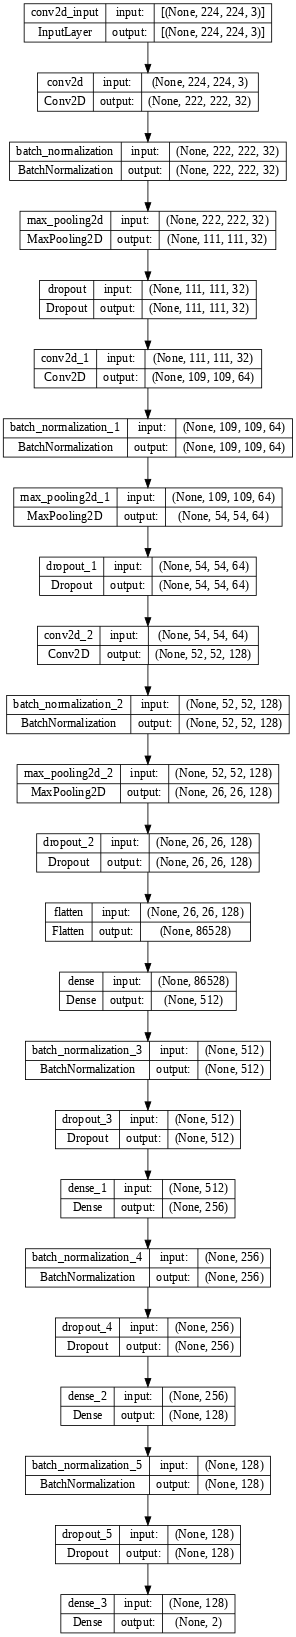

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Fit the model


In [ ]:
epochs=20
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
1333/1333 [==============================] - ETA: 0s - loss: 0.7091 - accuracy: 0.6116
Epoch 1: val_accuracy improved from -inf to 0.62843, saving model to  /content/gdrive/MyDrive/R2/Data/dogs-vs-cats/cp.ckpt


1333/1333 [==============================] - 275s 197ms/step - loss: 0.7091 - accuracy: 0.6116 - val_loss: 0.6512 - val_accuracy: 0.6284 - lr: 0.0010
Epoch 2/20
1333/1333 [==============================] - ETA: 0s - loss: 0.5668 - accuracy: 0.7064
Epoch 2: val_accuracy improved from 0.62843 to 0.75315, saving model to  /content/gdrive/MyDrive/R2/Data/dogs-vs-cats/cp.ckpt


1333/1333 [==============================] - 263s 197ms/step - loss: 0.5668 - accuracy: 0.7064 - val_loss: 0.5040 - val_accuracy: 0.7532 - lr: 0.0010
Epoch 3/20
1333/1333 [==============================] - ETA: 0s - loss: 0.5233 - accuracy: 0.7439
Epoch 3: val_accuracy improved from 0.75315 to 0.77397, saving model to  /content/gdrive/MyDrive/R2/Data/dogs-vs-cats/cp.ckpt


1333/1333 [==============================] - 263s 197ms/step - loss: 0.5233 - accuracy: 0.7439 - val_loss: 0.4711 - val_accuracy: 0.7740 - lr: 0.0010
Epoch 4/20
1333/1333 [==============================] - ETA: 0s - loss: 0.4787 - accuracy: 0.7754
Epoch 4: val_accuracy improved from 0.77397 to 0.81762, saving model to  /content/gdrive/MyDrive/R2/Data/dogs-vs-cats/cp.ckpt


1333/1333 [==============================] - 264s 198ms/step - loss: 0.4787 - accuracy: 0.7754 - val_loss: 0.4038 - val_accuracy: 0.8176 - lr: 0.0010
Epoch 5/20
1333/1333 [==============================] - ETA: 0s - loss: 0.4485 - accuracy: 0.7966
Epoch 5: val_accuracy improved from 0.81762 to 0.82062, saving model to  /content/gdrive/MyDrive/R2/Data/dogs-vs-cats/cp.ckpt


1333/1333 [==============================] - 263s 197ms/step - loss: 0.4485 - accuracy: 0.7966 - val_loss: 0.4056 - val_accuracy: 0.8206 - lr: 0.0010
Epoch 6/20
1333/1333 [==============================] - ETA: 0s - loss: 0.4283 - accuracy: 0.8070
Epoch 6: val_accuracy did not improve from 0.82062
1333/1333 [==============================] - 260s 195ms/step - loss: 0.4283 - accuracy: 0.8070 - val_loss: 0.3989 - val_accuracy: 0.8206 - lr: 0.0010
Epoch 7/20
1333/1333 [==============================] - ETA: 0s - loss: 0.4052 - accuracy: 0.8185
Epoch 7: val_accuracy did not improve from 0.82062
1333/1333 [==============================] - 258s 194ms/step - loss: 0.4052 - accuracy: 0.8185 - val_loss: 0.4943 - val_accuracy: 0.7966 - lr: 0.0010
Epoch 8/20
1333/1333 [==============================] - ETA: 0s - loss: 0.3704 - accuracy: 0.8386
Epoch 8: val_accuracy did not improve from 0.82062
1333/1333 [==============================] - 257s 193ms/step - loss: 0.3704 - accuracy: 0.8386 - val_lo

1333/1333 [==============================] - 261s 196ms/step - loss: 0.3577 - accuracy: 0.8439 - val_loss: 0.3305 - val_accuracy: 0.8569 - lr: 5.0000e-04
Epoch 10/20
1333/1333 [==============================] - ETA: 0s - loss: 0.3487 - accuracy: 0.8469
Epoch 10: val_accuracy improved from 0.85686 to 0.87027, saving model to  /content/gdrive/MyDrive/R2/Data/dogs-vs-cats/cp.ckpt


1333/1333 [==============================] - 261s 196ms/step - loss: 0.3487 - accuracy: 0.8469 - val_loss: 0.3236 - val_accuracy: 0.8703 - lr: 5.0000e-04
Epoch 11/20
1333/1333 [==============================] - ETA: 0s - loss: 0.3388 - accuracy: 0.8555
Epoch 11: val_accuracy did not improve from 0.87027
1333/1333 [==============================] - 258s 193ms/step - loss: 0.3388 - accuracy: 0.8555 - val_loss: 0.3458 - val_accuracy: 0.8599 - lr: 5.0000e-04
Epoch 12/20
1333/1333 [==============================] - ETA: 0s - loss: 0.3361 - accuracy: 0.8590
Epoch 12: val_accuracy did not improve from 0.87027
1333/1333 [==============================] - 259s 194ms/step - loss: 0.3361 - accuracy: 0.8590 - val_loss: 0.3234 - val_accuracy: 0.8681 - lr: 5.0000e-04
Epoch 13/20
1333/1333 [==============================] - ETA: 0s - loss: 0.3199 - accuracy: 0.8674
Epoch 13: val_accuracy did not improve from 0.87027
1333/1333 [==============================] - 257s 193ms/step - loss: 0.3199 - accurac

1333/1333 [==============================] - 261s 195ms/step - loss: 0.3085 - accuracy: 0.8710 - val_loss: 0.3023 - val_accuracy: 0.8775 - lr: 2.5000e-04
Epoch 15/20
1333/1333 [==============================] - ETA: 0s - loss: 0.3027 - accuracy: 0.8752
Epoch 15: val_accuracy improved from 0.87748 to 0.90250, saving model to  /content/gdrive/MyDrive/R2/Data/dogs-vs-cats/cp.ckpt


1333/1333 [==============================] - 261s 196ms/step - loss: 0.3027 - accuracy: 0.8752 - val_loss: 0.2633 - val_accuracy: 0.9025 - lr: 2.5000e-04
Epoch 16/20
1333/1333 [==============================] - ETA: 0s - loss: 0.3072 - accuracy: 0.8743
Epoch 16: val_accuracy did not improve from 0.90250
1333/1333 [==============================] - 260s 195ms/step - loss: 0.3072 - accuracy: 0.8743 - val_loss: 0.2786 - val_accuracy: 0.8957 - lr: 2.5000e-04
Epoch 17/20
1333/1333 [==============================] - ETA: 0s - loss: 0.2954 - accuracy: 0.8795
Epoch 17: val_accuracy did not improve from 0.90250
1333/1333 [==============================] - 266s 199ms/step - loss: 0.2954 - accuracy: 0.8795 - val_loss: 0.2561 - val_accuracy: 0.8987 - lr: 2.5000e-04
Epoch 18/20
1333/1333 [==============================] - ETA: 0s - loss: 0.2867 - accuracy: 0.8840
Epoch 18: val_accuracy improved from 0.90250 to 0.91051, saving model to  /content/gdrive/MyDrive/R2/Data/dogs-vs-cats/cp.ckpt


1333/1333 [==============================] - 270s 203ms/step - loss: 0.2867 - accuracy: 0.8840 - val_loss: 0.2303 - val_accuracy: 0.9105 - lr: 1.2500e-04
Epoch 19/20
1333/1333 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.8854
Epoch 19: val_accuracy did not improve from 0.91051
1333/1333 [==============================] - 267s 200ms/step - loss: 0.2819 - accuracy: 0.8854 - val_loss: 0.2508 - val_accuracy: 0.9055 - lr: 1.2500e-04
Epoch 20/20
1333/1333 [==============================] - ETA: 0s - loss: 0.2781 - accuracy: 0.8874
Epoch 20: val_accuracy did not improve from 0.91051
1333/1333 [==============================] - 267s 200ms/step - loss: 0.2781 - accuracy: 0.8874 - val_loss: 0.2281 - val_accuracy: 0.9089 - lr: 1.2500e-04


In [ ]:
#Saving from epoch 10 since that's where accuracy scores stopped improving significanty
model.save_weights(checkpoint_path.format(epoch=10))

In [ ]:
model.save_weights("model.h5")

# Check Loss and Accuracy scores

Everything is going in the right direction. Training and validation are matched up well enough and I feel confident that I've avoided significat overfitting or underfitting.

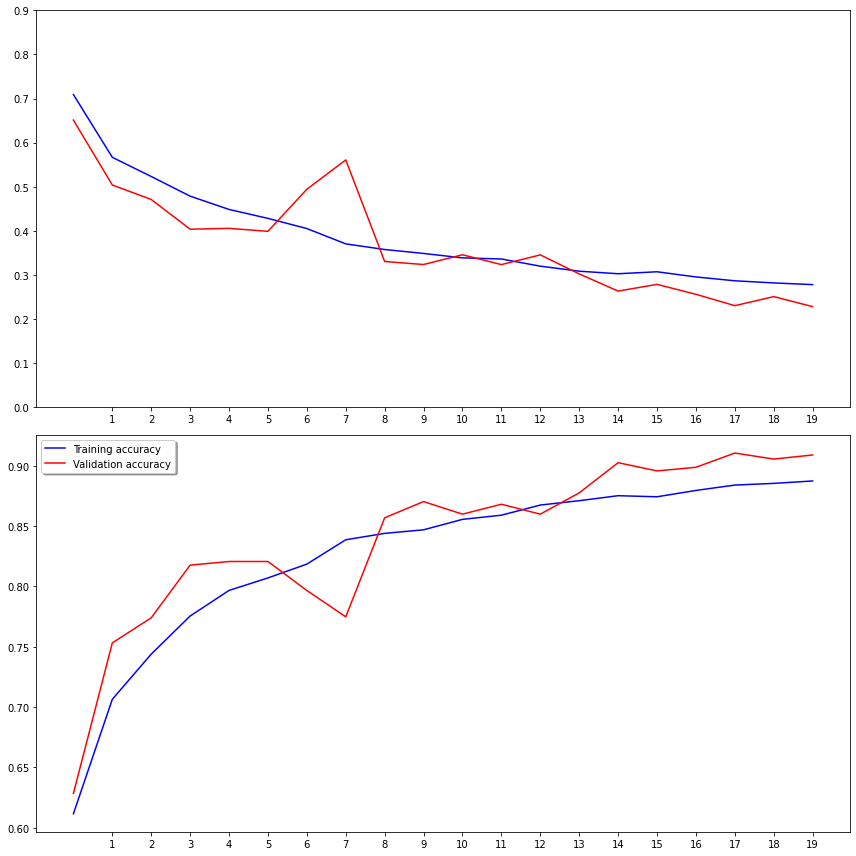

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Confusion Matrix


In [ ]:
from sklearn import metrics

In [ ]:
### Training data

train_predict= model.predict(train_generator)


1334/1334 [==============================] - 238s 179ms/step


In [ ]:
train_predict.shape


(20000, 2)

In [ ]:
train_df['prediction'] = np.argmax(train_predict, axis=-1)

In [ ]:
train_df['prediction'].value_counts()

0    11011
1     8989
Name: prediction, dtype: int64

In [ ]:
category_number = []
for x in train_df['category']:
  if x == 'cat':
    category_number.append(0)
  else:
    category_number.append(1)


In [ ]:
train_df['category_number'] = category_number

In [ ]:
train_df.head(5)

,filename,category,prediction,category_number
0,cat.5892.jpg,cat,1,0
1,cat.11691.jpg,cat,1,0
2,cat.3720.jpg,cat,1,0
3,dog.9490.jpg,dog,1,1
4,dog.273.jpg,dog,1,1


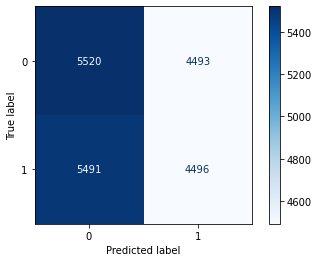

              precision    recall  f1-score   support

           0       0.50      0.55      0.53     10013
           1       0.50      0.45      0.47      9987

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



In [ ]:
train_set_confusion_matrix = metrics.confusion_matrix(train_df["category_number"], train_df["prediction"])
metrics.ConfusionMatrixDisplay(train_set_confusion_matrix).plot(cmap='Blues')
plt.show()

print(metrics.classification_report(train_df["category_number"], train_df["prediction"]))

In [ ]:
val_predict= model.predict(validation_generator)

334/334 [==============================] - 15s 44ms/step


In [ ]:
validate_df['prediction'] = np.argmax(val_predict, axis=-1)

In [ ]:
category_number = []
for x in validate_df['category']:
  if x == 'cat':
    category_number.append(0)
  else:
    category_number.append(1)
validate_df['category_number'] = category_number

In [ ]:
validate_df.head()

,filename,category,prediction,category_number
0,dog.10419.jpg,dog,0,1
1,dog.7021.jpg,dog,1,1
2,cat.3525.jpg,cat,0,0
3,dog.7008.jpg,dog,0,1
4,cat.3072.jpg,cat,1,0


In [ ]:
#Predict
y_prediction = model.predict(x_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)

# Create Testing Generator & Get Predictions

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [ ]:
predict = model.predict(test_generator, steps=np.ceil(total_samples/batch_size))

834/834 [==============================] - 40s 47ms/step


Looking at the probability of the predictions

In [ ]:
print([predict[i] for i in range(20)])

[array([0.991248  , 0.00875201], dtype=float32), array([0.9913216 , 0.00867838], dtype=float32), array([0.99439186, 0.00560813], dtype=float32), array([0.02400562, 0.97599435], dtype=float32), array([0.01235514, 0.98764485], dtype=float32), array([0.9924034 , 0.00759658], dtype=float32), array([0.11182023, 0.88817984], dtype=float32), array([0.7268223 , 0.27317768], dtype=float32), array([0.3646166, 0.6353834], dtype=float32), array([0.9544911 , 0.04550896], dtype=float32), array([0.0275139 , 0.97248614], dtype=float32), array([0.02953389, 0.9704661 ], dtype=float32), array([0.9744407 , 0.02555931], dtype=float32), array([0.01005978, 0.9899402 ], dtype=float32), array([0.3442747, 0.6557253], dtype=float32), array([0.98465204, 0.01534792], dtype=float32), array([0.99837613, 0.00162387], dtype=float32), array([0.02267389, 0.9773261 ], dtype=float32), array([0.00310991, 0.9968901 ], dtype=float32), array([0.05709211, 0.94290787], dtype=float32)]


In [ ]:
print([np.argmax(predict[i]) for i in range(20)])

[0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1]


In [ ]:
predict.accuracy

# Add prediction and confidence scores to test dataframe

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
test_df['confidence'] = np.max(predict, axis=-1)

In [ ]:
test_df.head()

,filename,category,confidence
0,4589.jpg,0,0.991248
1,2967.jpg,0,0.991322
2,7997.jpg,0,0.994392
3,10826.jpg,1,0.975994
4,3688.jpg,1,0.987645


The balance of predictions looks good. It matches the balance from the training set which is a good sign...

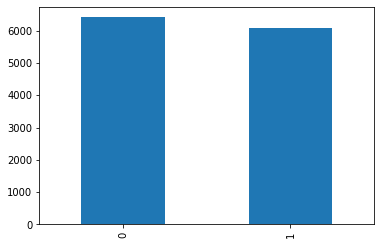

In [ ]:
test_df['category'].value_counts().plot.bar()

# Verify Predictions


Text(0.5, 0, 'cat 100% confidence')

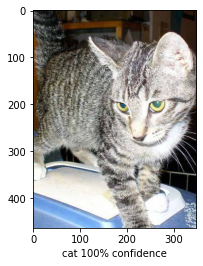

In [ ]:
# Take a look at random test images with predictions and see how the model did!
i = random.randrange(total_samples)
sample = test_df.iloc[i]


image = load_img("./test1/"+sample['filename'])
plt.imshow(image)
plt.xlabel("{} {:2.0f}% confidence".format(class_names[sample['category']],
                                100*(sample['confidence'])))

What does the model do with an image of both a cat AND a dog?

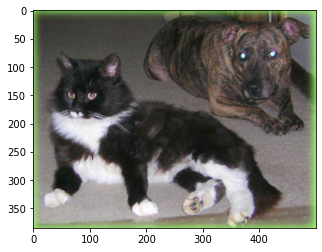

In [ ]:
image = load_img("./train/cat.10181.jpg")
plt.imshow(image)

In [ ]:
new = {'filename': ['cat.10181.jpg']}

In [ ]:
both_df = pd.DataFrame(new)

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    both_df, 
    "./train/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 1 validated image filenames.


In [ ]:
both_model = model.predict(test_generator, steps=np.ceil(1/batch_size))

1/1 [==============================] - 0s 36ms/step


So, when presented with an image of both a dog and a cat, the model chose dog in this case. 

In [ ]:
both_model

array([[0.22313385, 0.7768662 ]], dtype=float32)

In [ ]:
np.argmax(both_model[0])

1